In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
#plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.utils import resample
#sns.set(style="white")
#sns.set(style="whitegrid", color_codes=True)

In [2]:
listings = pd.read_csv("listing_update/listingsUpdateOut.csv")
neighb = pd.read_csv("neighbourhoods_update/neighbourhoods_update.csv", sep = ",")
main = pd.merge(listings, neighb, how="inner", on="neighbourhood_group")
sentiment= pd.read_csv("sentiment analysis/sentiment.csv")


sentiment= sentiment.rename(columns={"listing_id": "id"})
main2 = pd.merge(main, sentiment, how= "inner", on="id")

## Loogistic regression

In [3]:
datalog=main2[['price','minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'nr_of_bathrooms',
       'bedrooms', 'accommodates', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','coefficient_of_location', 'purchase_power_pc', 'crime_rate_pc',
       'population_density', 'other_touristic_accomodations', 'Polarity']]

In [38]:
y= datalog[['host_is_superhost']]
x = datalog[["number_of_reviews", 'coefficient_of_location', "nr_of_bathrooms", "bedrooms", "review_scores_rating", "purchase_power_pc", "crime_rate_pc", "population_density", "host_response_rate", "Polarity"]]

In [5]:
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.613649
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:  0.072      
Dependent Variable:    host_is_superhost  AIC:               241478.4837
Date:                  2022-05-02 18:01   BIC:               241580.3800
No. Observations:      196740             Log-Likelihood:    -1.2073e+05
Df Model:              9                  LL-Null:           -1.3012e+05
Df Residuals:          196730             LLR p-value:       0.0000     
Converged:             1.0000             Scale:             1.0000     
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
number_of_reviews        0.0048   0.0001  78.2122 0

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.66


In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[32856  4255]
 [15886  6025]]


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77     37111
           1       0.59      0.27      0.37     21911

    accuracy                           0.66     59022
   macro avg       0.63      0.58      0.57     59022
weighted avg       0.64      0.66      0.62     59022



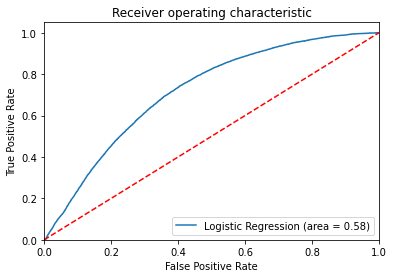

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

## SVM

In [11]:
len(datalog)

196740

In [12]:
#resampling the data
datalogSuperHost=datalog[datalog["host_is_superhost"]== 1]
datalogHost=datalog[datalog["host_is_superhost"]== 0]

In [13]:
#downsample
datalogSuperHost_downsample= resample(datalogSuperHost, replace= False, n_samples= 1000, random_state=42)

len(datalogSuperHost_downsample)

datalogHost_downsample= resample(datalogHost, replace= False, n_samples= 1000, random_state=42)

print(len(datalogSuperHost_downsample))
len(datalogHost_downsample)

1000


1000

In [14]:
#concacenating
datalog_downsample= pd.concat([datalogHost_downsample,datalogSuperHost_downsample])
len(datalog_downsample)

2000

In [15]:
datalog_downsample

price  minimum_nights  number_of_reviews  reviews_per_month  \
46999     161               1                 62               0.97   
96426      61               2                122               2.95   
137801    110               2                 11               0.41   
40072      61               5                131               1.94   
100822     88               3                 34               0.86   
...       ...             ...                ...                ...   
75861      75               2                 36               0.78   
35129      75               3                  7               0.10   
49240      72               1                199               3.23   
66358      23               2                106               2.07   
40407      33               2                174               2.59   

        calculated_host_listings_count  availability_365  \
46999                               38               317   
96426                                1               346   
137801                              10                65   
40072                                2                 6   
100822                              24               350   
...                                ...               ...   
75861                               30               214   
35129                                2               324   
49240                                3                 0   
66358                                4               123   
40407                                1                81   

        number_of_reviews_ltm  host_response_time  host_response_rate  \
46999                       3                   1                0.98   
96426                      24                   1                1.00   
137801                      4                   1                1.00   
40072                       9                   3                0.50   
100822                      0                   1                1.00   
...                       ...                 ...                 ...   
75861                       7                   1                1.00   
35129                       4                   1                1.00   
49240                       0                   1                1.00   
66358                       7                   1                1.00   
40407                      27                   1                1.00   

        host_is_superhost  ...  review_scores_checkin  \
46999                   0  ...                   4.61   
96426                   0  ...                   4.78   
137801                  0  ...                   4.90   
40072                   0  ...                   4.85   
100822                  0  ...                   4.03   
...                   ...  ...                    ...   
75861                   1  ...                   4.94   
35129                   1  ...                   4.86   
49240                   1  ...                   4.89   
66358                   1  ...                   4.83   
40407                   1  ...                   4.93   

        review_scores_communication  review_scores_location  \
46999                          4.69                    4.86   
96426                          4.89                    4.72   
137801                         5.00                    4.90   
40072                          4.86                    4.91   
100822                         4.68                    4.79   
...                             ...                     ...   
75861                          4.83                    4.83   
35129                          5.00                    4.57   
49240                          4.97                    4.63   
66358                          4.86                    4.71   
40407                          4.95                    4.78   

        review_scores_value  coefficient_of_location  purchase_power_pc  \
46999                  4.44             

In [16]:
x1= datalog_downsample.drop("host_is_superhost", axis=1)
y1= datalog_downsample["host_is_superhost"]

In [17]:
from sklearn import svm

In [18]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.3, random_state=42)
X1_train_scaled=scale(X1_train)
X1_test_scaled=scale(X1_test)

In [19]:
clf = svm.SVC(random_state=42) 
clf.fit(X1_train_scaled, y1_train)

SVC(random_state=42)

In [20]:
from sklearn import metrics
y_pred1 = clf.predict(X1_test_scaled)
print("Accuracy:",metrics.accuracy_score(y1_test, y_pred1))

Accuracy: 0.7616666666666667


In [21]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,
                     X1_test_scaled,
                     y1_test,
                     values_format='d')

In [22]:
param_grid=[
    {'C': [0.5,1,10,100],
     "gamma": ['scale',1,0.1,0.01,0.001, 0.0001],
     'kernel': ['rbf']}
]

In [23]:
optimal_params= GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=0)

In [24]:
optimal_params.fit(X1_train_scaled,y1_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [25]:
clf_svm= svm.SVC(random_state=42, C=10, gamma= 0.01)
clf_svm.fit(X1_train_scaled,y1_train)

SVC(C=10, gamma=0.01, random_state=42)

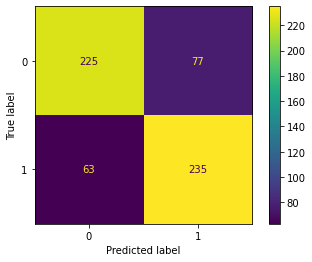

In [26]:
plot_confusion_matrix(clf_svm,
                     X1_test_scaled,
                     y1_test,
                     values_format='d')

In [27]:
y_pred2 = clf_svm.predict(X1_test_scaled)
print("Accuracy:",metrics.accuracy_score(y1_test, y_pred2))

Accuracy: 0.7666666666666667


In [28]:
len(datalog_downsample.columns)

25

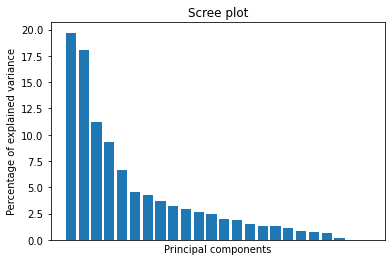

In [29]:
#Doing PCA
pca= PCA()
X_train_pca=pca.fit_transform(X1_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels= [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis="x",
    which="both",
    bottom= False,
    top= False,
    labelbottom= False)

plt.ylabel("Percentage of explained variance")
plt.xlabel("Principal components")
plt.title("Scree plot")
plt.show()


In [30]:
#using pca in SVM
train_pca1_coords= X_train_pca[:, 0]
train_pca2_coords= X_train_pca[:, 1]

#scaling the data
pca_train_scaled= scale(np.column_stack((train_pca1_coords,train_pca2_coords)))

In [31]:
param_grid=[
    {'C': [0.5,1,10,100],
     "gamma": ['scale',1,0.1,0.01,0.001, 0.0001],
     'kernel': ['rbf']}
]

In [32]:
optimal_params= GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=0)

In [33]:
optimal_params.fit(pca_train_scaled,y1_train)
print(optimal_params.best_params_)

{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


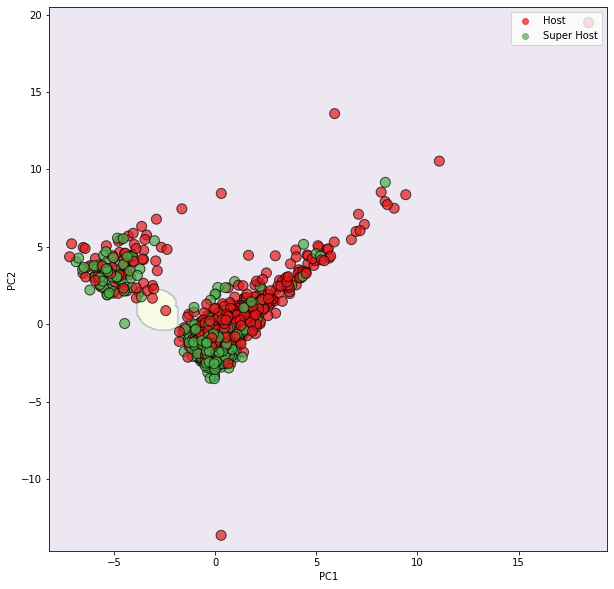

In [34]:
import matplotlib.colors as colors
clf_svm = svm.SVC(random_state=42, C=0.5, gamma= "scale")
clf_svm.fit(pca_train_scaled,y1_train)

X_test_pca =pca.transform(X1_train_scaled)
test_pca1_coords= X_test_pca[:, 0]
test_pca2_coords= X_test_pca[:, 1]


x_min= test_pca1_coords.min() -1
x_max= test_pca1_coords.max() +1

y_min= test_pca2_coords.min() -1
y_max= test_pca2_coords.max() +1

xx, yy= np.meshgrid(np.arange(start=x_min, stop=x_max, step= 0.1),
                   np.arange(start=y_min, stop= y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)
fig, ax= plt.subplots(figsize=(10,10))
ax.contourf(xx, yy, Z, alpha= 0.1)

cmap=colors.ListedColormap(['#e41a1c','#4daf4a'])

scatter= ax.scatter(test_pca1_coords, test_pca2_coords, c=y1_train,
                   cmap=cmap,
                   s=100,
                   edgecolors='k',
                   alpha=0.7)
legend= ax.legend(scatter.legend_elements()[0],
                 scatter.legend_elements()[1],
                 loc='upper right')

legend.get_texts()[0].set_text("Host")
legend.get_texts()[1].set_text("Super Host")

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
plt.show()

## Decision tree

In [35]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

In [36]:
x

number_of_reviews  coefficient_of_location  nr_of_bathrooms  bedrooms  \
0                     127                     2.20              1.0       1.0   
1                     127                     2.90              1.0       1.0   
2                     127                     2.95              1.0       1.0   
3                     127                     2.60              1.0       1.0   
4                     127                     2.90              1.0       1.0   
...                   ...                      ...              ...       ...   
196735                  3                     1.65              1.0       1.0   
196736                  2                     1.80              1.0       1.0   
196737                  2                     1.75              1.0       1.0   
196738                  2                     1.75              1.0       1.0   
196739                  2                     1.65              1.0       1.0   

        review_scores_rating  purchase_power_pc  crime_rate_pc  \
0                       4.81              205.6           49.7   
1                       4.81              205.6           49.7   
2                       4.81              205.6           49.7   
3                       4.81              205.6           49.7   
4                       4.81              205.6           49.7   
...                      ...                ...            ...   
196735                  4.67               88.8           18.9   
196736                  4.50               88.8           18.9   
196737                  4.50               88.8           18.9   
196738                  4.50               88.8           18.9   
196739                  4.50               88.8           18.9   

        population_density  host_response_rate  Polarity  
0                   5093.1                1.00  0.302364  
1                   5093.1                1.00  0.302364  
2                   5093.1                1.00  0.302364  
3                   5093.1                1.00  0.302364  
4                   5093.1                1.00  0.302364  
...                    ...                 ...       ...  
196735              6118.6                0.83  0.386111  
196736              6118.6                0.80  0.233333  
196737              6118.6                0.80  0.233333  
196738              6118.6                0.80  0.233333  
196739              6118.6                0.80  0.233333  

[196740 rows x 10 columns]

In [39]:
X2_train, X2_test, y2_train, y2_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [40]:
clf = DecisionTreeClassifier()
clf = clf.fit(X2_train,y2_train)

In [41]:
y_pred3 = clf.predict(X2_test)
print("Accuracy:",metrics.accuracy_score(y2_test, y_pred3))

Accuracy: 0.9973230320897293


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.264459 to fit



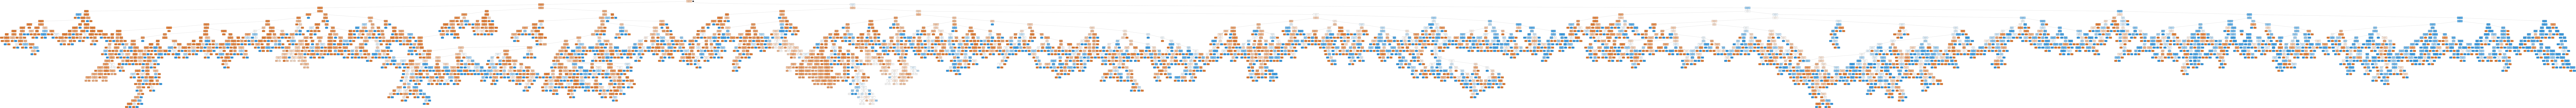

In [42]:
#Visualizing the tree
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

feature_cols=['number_of_reviews', 'coefficient_of_location', 'nr_of_bathrooms',
       'bedrooms', 'review_scores_rating', 'purchase_power_pc',
       'crime_rate_pc', 'population_density', 'host_response_rate',
       'Polarity']
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#graph.write_png('superhost.png')
Image(graph.create_png())


In [43]:
#pruning the tree
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X2_train,y2_train)


y_pred4 = clf.predict(X2_test)


print("Accuracy:",metrics.accuracy_score(y2_test, y_pred4))

Accuracy: 0.7337433499373115


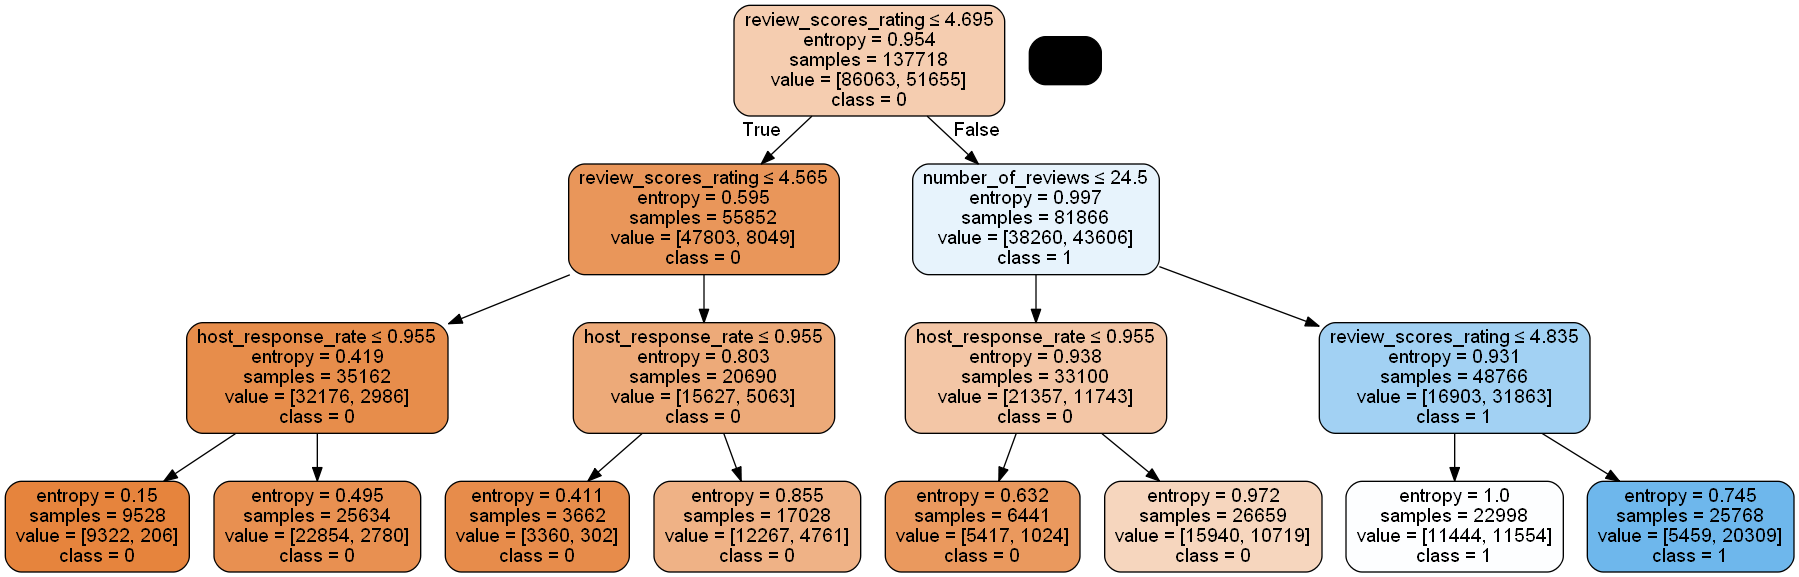

In [44]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('prunnedtree.png')
Image(graph.create_png())